# Introduction

A cold atom experimental setup on an optical table is a useful metaphor for the philosophy underlying the cold-atom library. In such an experimental apparatus there are expensive, complicated gadgets like lasers, detectors, vacuum pumps, etc. Usually these gadgets are not chosen so as to maximize their performance for a specific experiment. Rather they are reasonably versatile and general so that they can be repurposed for different experiments. Of course this saves cost but more importantly it allows experimenters to adapt to new insights that are gained only once construction of the apparatus has begun or once the experiment is underway. This is a recognition of the reality that it is impossible to fully anticipate all details of an experiment and to have a perfect plan ahead of time. A certain amount of on the fly learning and adaptation to new information is necessary.

The expensive and sophisticated gadgets are connected together by a large number of highly standardized, very general, and typically low cost components: optical fibers, various types of cables, screws, bolts, mounts, wire, duct tape etc. The use of these very general, low cost interfaces is what allows students in the field of cold atoms to get to the point where they can take data and carry out physics research in a matter of years (sometimes even months).

The cold-atom library aims to emulate this approach for computational research in cold atoms. The library itself provides powerful data structures, algorithms, and implementations for specialized tasks (e.g. particle tracking, laser cooling, etc). In our analogy these capabilities correspond to lasers and other equipment. The interface between these capabilities is based on widely used standard libraries such as numpy and matplotlib and the programming language python itself.

This architecture is in deliberate contrast to simulation software that is specialized for a rather specific and narrow application domain (e.g. fusion research). Such applications are designed and developed over many years and decades and simulation runs are often carried out on super computers using batch systems with turnaround times of hours or days. Granted, for many of the application areas where these traditional computational solutions are brought to bear this approach is the only practical one.

But in our opinion it is a poor fit for cold atom research where flexibility, agility, and interactivity are more important than application performance. Of course this is practical only because the computational needs in the flavor of atomic physics we're targeting are much less stringent than in traditional areas of computational science.

This notebook illustrates some of the most basic concepts of the cold atoms library. We show how to represent an ensemble of particles and how to simulate their ballistic expansion.


# Ballistic expansion of an ensemble of cold atoms

First we need to include a few libraries. As mentioned in the introduction, the coldatoms library uses numpy to represent most of its data. matplotlib is our go to solution for visualization

In [1]:
import coldatoms
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt

Collections of particles are represented by the Ensemble class, which essentially contains their positions and velocities. While it is possible to consider particles in reduced dimensions (e.g. 1D or 2D) the cold-atoms library is designed for three spatial dimensions. This is because cold-atoms is at its heart a mesh-free library where the cost of higher dimensions (e.g. 3D vs 2D) is rather low. Therefore there is little incentive to save cost by considering lower dimensional problems. Some functions and classes assume that we're in three spatial dimensions. If you're deviating from that you're on your own!

In addition to positions and velocities ensembles of particles can have ensemble properties and per particle properties. Ensemble properties uniformly apply to all particles in the ensemble. A common example of an ensemble property are the particle mass or dipole matrix element in an ensemble of idential particles. A typical example of per particle state is the internal state of the atoms.

As an example, lets consider a bunch of particles distributed according to a Gaussian density distribution and a Maxwell-Boltzmann velocity distribution:

In [4]:
N = 1000
ensemble = coldatoms.Ensemble(num_ptcls=N)
ensemble.x = np.random.normal(size=(N, 3))
ensemble.v = np.random.normal(size=(N, 3))

In cold-atoms functions and algorithms operate on whole Ensembles rather than individual particles. This is by design. Dealing with whole ensembles allows us to construct high performance building blocks out of which simulations can then be assembled. If the library worked at the level of individual particles it would be impossible to amortize the cost of some of the glue code needed to tie the different components together. The result would be slow performance.

For the same reasons it is typically more efficient to use ensemble properties rather than per particle properties when possible.

If we let the particles evolve without any forces being applied to them we get ballistic expansion. The following figure shows the initial density distribution and the density distribution after free expansion at two later times.

<IPython.core.display.Javascript object>


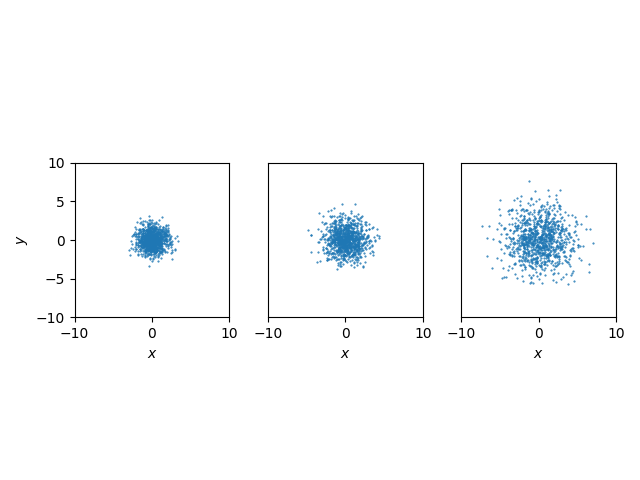

In [6]:
def plot_positions(ax, x, y, x_range, y_range):
    ax.plot(x, y,'.',markersize=1)
    ax.set_xlim(-x_range, x_range)
    ax.set_ylim(-y_range, y_range)
    ax.set_aspect(1)
    
fig = plt.figure()
subplots = [plt.subplot(131), plt.subplot(132), plt.subplot(133)]

for ax in subplots:
    plot_positions(ax, ensemble.x[:,0], ensemble.x[:, 1], 10, 10)
    coldatoms.drift_kick(1.0, ensemble)
    ax.set_xlabel(r'$x$')

subplots[0].set_ylabel(r'$y$')
subplots[1].get_yaxis().set_ticks([])
subplots[2].get_yaxis().set_ticks([])
fig.tight_layout()

# Some basic performance estimates

To get a rough idea of the performance of our particle push algorithm we measure the time it takes to update the positions of a certain number of particles:

In [11]:
import time

def time_ballistic(n):
    ensemble = coldatoms.Ensemble(num_ptcls=n)
    ensemble.x = np.random.normal(size=(n, 3))
    ensemble.v = np.random.normal(size=(n, 3))
    t = time.time()
    num_iter = 10
    for i in range(num_iter):
        coldatoms.drift_kick(0.1, ensemble)
    elapsed = time.time() - t
    return elapsed / num_iter

To update the positions of n particles we need at least 2x3xn floating point operations:

In [8]:
def flops(n):
    return 2 * n * 3

And we need to read at least 2x8xn bytes of data:

In [9]:
def bandwidth(n):
    return 2 * np.dtype('float64').itemsize * n

The following figure shows the performance we end up with on my laptop. This figure shows the read bandwidth in GB/s and the arithmetic throughput in GFLOP/s. Note that the write bandwdith requirements of this kernel are only half as large as the read bandwdith. The write bandwidth is therefore not a limiting factor because write and read bandwidth of chipsets are typically comaparable.

The particle push kernel has very low arithmetic intensity. For every byte that is brought from main memory into registers we only perform 1/8th of an arithmetic operation. Therfore this kernel is very much bandwidth limited.

The peak bandwidth that our implementation attains is less than 2 GB/s. Mild cache effects are apparent in the data. The peak bandwidth of our system as measured with the stream triad benchmark is just over 5 GB/s. For large numbers of particles (more than fit into last level cache) our implementation achieves only about 0.7 GB/s. These results indicate that there is quite a bit of room for improvement.

<IPython.core.display.Javascript object>


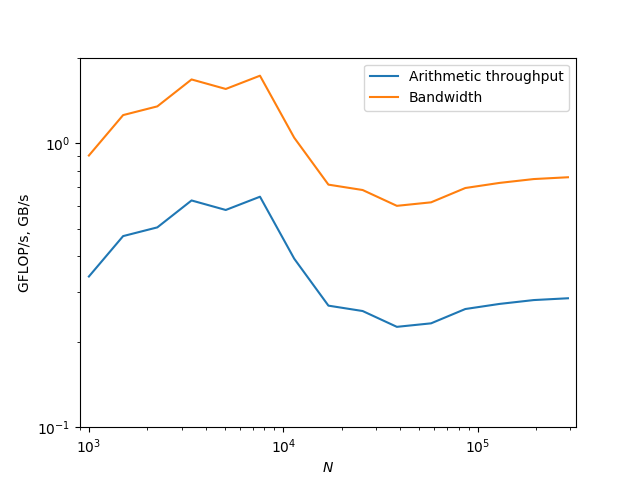

In [12]:
import math

nptcls = np.array([1000*1.5**e for e in range(0, 15)])
times = np.array([time_ballistic(math.floor(n)) for n in nptcls])
gflops = flops(nptcls) / times / (2.0**30)
gbytes = bandwidth(nptcls) / times / (2.0**30)

plt.figure()
gflops_plot = plt.loglog(nptcls, gflops)
bw_plot = plt.loglog(nptcls, gbytes)
plt.xlim([0.9 * nptcls[0], 1.1 * nptcls[-1]])
plt.ylim([0.1, 2.0])
plt.xlabel(r'$N$')
plt.ylabel('GFLOP/s, GB/s')
plt.legend(['Arithmetic throughput', 'Bandwidth']);